In [12]:
import numpy as np
import sigpy as sp
from sigpy import mri as mr
from sigpy import plot as pl
import scipy.io as sio
import matplotlib.pyplot as plt

# Cartesian Case - L1 Wavelet FISTA

In [2]:
class L1WaveletRecon(sp.app.App):
    def __init__(self, ksp, mask, mps, lamda, max_iter):
        img_shape = mps.shape[1:]
        
        S = sp.linop.Multiply(img_shape, mps)
        F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
        P = sp.linop.Multiply(ksp.shape, mask)
        self.W = sp.linop.Wavelet(img_shape)
        A = P * F * S * self.W.H
        
        proxg = sp.prox.L1Reg(A.ishape, lamda)
        
        self.wav = np.zeros(A.ishape, np.complex64)
        alpha = 1
        def gradf(x):
            return A.H * (A * x - ksp)

        alg = sp.alg.GradientMethod(gradf, self.wav, alpha, proxg=proxg, 
                                    max_iter=max_iter)
        super().__init__(alg)
        
    def _output(self):
        return self.W.H(self.wav)

In [28]:
class L1WaveletAKRecon(sp.app.App):
    def __init__(self, ksp, mask, mps, lamda, max_iter):
        img_shape = mps.shape[1:]
        
        S = sp.linop.Multiply(img_shape, mps)
        F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
        P = sp.linop.RightMatMul(ksp.shape, mask.T)
        self.W = sp.linop.Wavelet(img_shape)
        A = P * F * S * self.W.H
        
        proxg = sp.prox.L1Reg(A.ishape, lamda)
        
        self.wav = np.zeros(A.ishape, np.complex64)
        alpha = 1
        def gradf(x):
            return A.H * (A * x - ksp)

        alg = sp.alg.GradientMethod(gradf, self.wav, alpha, proxg=proxg, 
                                    max_iter=max_iter)
        super().__init__(alg)
        
    def _output(self):
        return self.W.H(self.wav)

In [8]:
max_iter = 30
lamda = 0.005

ksp = sio.loadmat('/home/antpc/Akash/NC_MRI/09-01-2024/EPIAcc3CartMaps.mat')
CartData = ksp['Cart_data']

CartData = np.transpose(CartData, (2,0,1))
print(CartData.shape)

(17, 192, 128)


In [17]:
mask = sio.loadmat('/home/antpc/Akash/NC_MRI/09-01-2024/Acc3AliasingMtx.mat')
mask = mask['S']

mps = mr.app.EspiritCalib(CartData[:15, :,:]).run()

EspiritCalib: 100%|██████████| 100/100 [00:01<00:00, 57.98it/s]


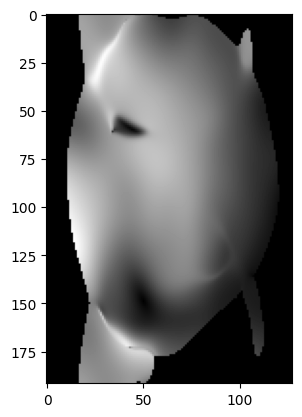

In [18]:
plt.imshow(np.abs(mps[1,:,:]), cmap ='gray')

In [29]:
img = L1WaveletAKRecon(CartData[:15,64:128,:], mask, mps, lamda, max_iter).run()
pl.ImagePlot(img)

ValueError: Invalid shapes: (15, 64, 128), (192, 64).

# Non Cartesian Case - L1 Wavelet FISTA